Dataset Shape: (1118669, 34)


,transaction_id,order_date,customer_id,product_id,product_name,category,subcategory,brand,original_price_inr,discount_percent,...,is_festival_sale,festival_name,customer_rating,return_status,order_month,order_year,order_quarter,product_weight_kg,is_prime_eligible,product_rating
0,TXN_2015_00000001,2015-01-25,CUST_2015_00003884,PROD_000021,Samsung Galaxy S6 16GB Black,Electronics,Smartphones,Samsung,123614.29,27.91,...,True,Republic Day Sale,5.0,Delivered,1,2015,1,0.19,True,4.7
1,TXN_2015_00000002,2015-05-01,CUST_2015_00011709,PROD_000055,OnePlus OnePlus 2 16GB White,Electronics,Smartphones,OnePlus,54731.86,0.00,...,False,NaN,4.5,Delivered,1,2015,1,0.20,True,4.1
2,TXN_2015_00000003,2015-01-24,CUST_2015_00004782,PROD_000039,Samsung Galaxy Note 5 64GB Black,Electronics,Smartphones,Samsung,97644.25,46.93,...,True,Republic Day Sale,NaN,Delivered,1,2015,1,0.17,True,3.3
3,TXN_2015_00000004,2015-01-28,CUST_2015_00008105,PROD_000085,Motorola Moto G (3rd Gen) 16GB Black,Electronics,Smartphones,Motorola,21947.26,0.00,...,False,NaN,3.0,Delivered,1,2015,1,0.22,True,3.5
4,TXN_2015_00000005,2015-01-31,CUST_2015_00002955,PROD_000055,OnePlus OnePlus 2 16GB White,Electronics,Smartphones,OnePlus,54731.86,0.00,...,False,NaN,4.0,Delivered,1,2015,1,0.20,True,4.1


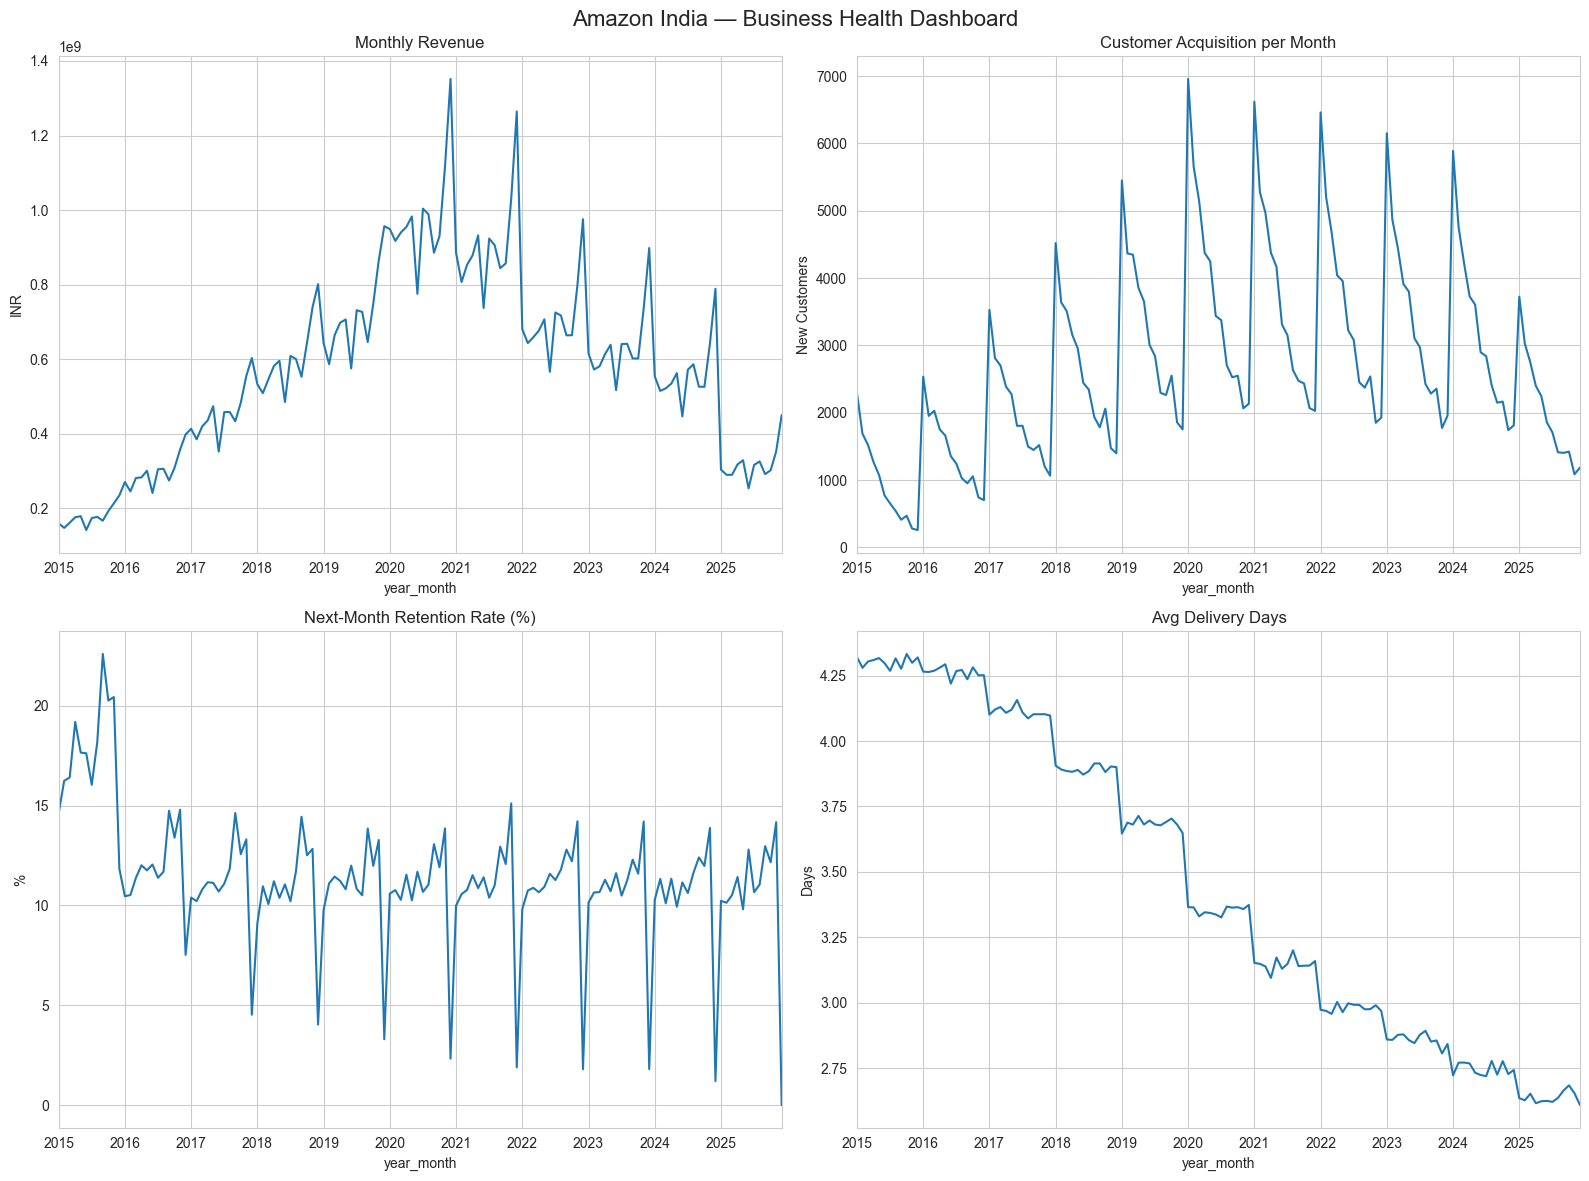

,Value
Total Revenue (INR),7.639566e+10
Avg Monthly Revenue Growth %,2.250046e+00
Total Customers,3.546190e+05
Repeat Purchase Rate %,7.405159e+01
Avg Delivery Days,3.321309e+00



📊 EXECUTIVE SUMMARY INSIGHTS:

1️⃣ Revenue Trend:
   - Track seasonal spikes and sustained growth phases.

2️⃣ Customer Acquisition:
   - Shows campaign and festival impacts over time.

3️⃣ Retention:
   - Indicates loyalty health and subscription value.

4️⃣ Operational Efficiency:
   - Delivery speed reflects logistics maturity.

5️⃣ Repeat Purchase Rate:
   - High values indicate strong platform stickiness.

✅ EDA_14 COMPLETED SUCCESSFULLY


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# ============================================================
# LOAD MASTER DATA
# ============================================================

df = pd.read_csv("../master/amazon_india_master_2015_2025.csv")

print("Dataset Shape:", df.shape)
display(df.head())

# ============================================================
# BASIC CLEAN
# ============================================================

df["order_date"] = pd.to_datetime(df["order_date"], errors="coerce")

num_cols = [
    "final_amount_inr",
    "quantity",
    "delivery_days",
]

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

df = df.dropna(
    subset=[
        "customer_id",
        "order_date",
        "final_amount_inr",
    ]
)

df["year_month"] = df["order_date"].dt.to_period("M")
df["year"] = df["order_date"].dt.year

# ============================================================
# KPI CALCULATIONS
# ============================================================

# ------------------------------------------------------------
# Revenue Trend
# ------------------------------------------------------------

monthly_revenue = (
    df.groupby("year_month")["final_amount_inr"]
      .sum()
)

monthly_revenue_growth = monthly_revenue.pct_change() * 100

# ------------------------------------------------------------
# Customer Acquisition (First Purchase Month)
# ------------------------------------------------------------

first_purchase = (
    df.groupby("customer_id")["year_month"]
      .min()
)

acq_by_month = first_purchase.value_counts().sort_index()

# ------------------------------------------------------------
# Retention Rate (Repeat Buyers Next Month)
# ------------------------------------------------------------

df_sorted = df.sort_values(["customer_id","order_date"])

df_sorted["next_month"] = (
    df_sorted.groupby("customer_id")["year_month"]
      .shift(-1)
)

df_sorted["retained_next_month"] = (
    df_sorted["next_month"]
    == (df_sorted["year_month"] + 1)
)

retention = (
    df_sorted.groupby("year_month")["retained_next_month"]
      .mean() * 100
)

# ------------------------------------------------------------
# Operational Efficiency Proxy
# ------------------------------------------------------------

delivery_eff = (
    df.groupby("year_month")["delivery_days"]
      .mean()
)

# ------------------------------------------------------------
# Repeat Purchase Rate
# ------------------------------------------------------------

cust_orders = df.groupby("customer_id")["transaction_id"].nunique()
repeat_rate = (cust_orders > 1).mean() * 100

# ============================================================
# MULTI-PANEL DASHBOARD
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Revenue Trend
monthly_revenue.plot(ax=axes[0,0])
axes[0,0].set_title("Monthly Revenue")
axes[0,0].set_ylabel("INR")

# Acquisition
acq_by_month.sort_index().plot(ax=axes[0,1])
axes[0,1].set_title("Customer Acquisition per Month")
axes[0,1].set_ylabel("New Customers")

# Retention
retention.plot(ax=axes[1,0])
axes[1,0].set_title("Next-Month Retention Rate (%)")
axes[1,0].set_ylabel("%")

# Delivery Efficiency
delivery_eff.plot(ax=axes[1,1])
axes[1,1].set_title("Avg Delivery Days")
axes[1,1].set_ylabel("Days")

plt.suptitle("Amazon India — Business Health Dashboard", fontsize=16)
plt.tight_layout()
plt.show()

# ============================================================
# EXECUTIVE KPI SUMMARY
# ============================================================

summary = {
    "Total Revenue (INR)": df["final_amount_inr"].sum(),
    "Avg Monthly Revenue Growth %": monthly_revenue_growth.mean(),
    "Total Customers": df["customer_id"].nunique(),
    "Repeat Purchase Rate %": repeat_rate,
    "Avg Delivery Days": df["delivery_days"].mean(),
}

display(pd.DataFrame(summary, index=["Value"]).T)

# ============================================================
# EXECUTIVE INSIGHTS
# ============================================================

print("\n📊 EXECUTIVE SUMMARY INSIGHTS:")

print("""
1️⃣ Revenue Trend:
   - Track seasonal spikes and sustained growth phases.

2️⃣ Customer Acquisition:
   - Shows campaign and festival impacts over time.

3️⃣ Retention:
   - Indicates loyalty health and subscription value.

4️⃣ Operational Efficiency:
   - Delivery speed reflects logistics maturity.

5️⃣ Repeat Purchase Rate:
   - High values indicate strong platform stickiness.
""")

print("✅ EDA_14 COMPLETED SUCCESSFULLY")
